# License Plate Recognition
Version 6
- Crop license plate from training and testing images.
- Fix the text length as 8 characters.
- Implement accuracy function.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Import Libraries

In [2]:
import os
import fnmatch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import string
import time
from glob import glob
from sklearn.model_selection import train_test_split
from keras.models import load_model, Sequential
from keras.utils import pad_sequences
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, Dropout
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

print("tf version =", tf.__version__)
tf.executing_eagerly()


tf version = 2.12.0


True

### Preprocessing

Input images are preprocessed as followings:

1. Read the image and convert into a gray-scale image
2. Make each image of size (128,32) by using resizing
3. Expand image dimension as (128,32,1) to make it compatible with the input shape of model architecture
4. Normalise the image pixel values by dividing it with 255.

Output labels are preprocessed as followings:

1. Read the text from the name of the image as the image name contains text written inside the image.
2. Encode each character of a word into index of character in the word. For example, [‘A’:10, ‘Z’:33 …….. ‘皖’:34, etc]. Let say we are having the word ‘ABAB’ then our encoded label would be [10,11,10,11]


In [3]:
### Crop license plates to create training and testing data

# Chinese EV license plate consists of eight characters:
# province (1 character), alphabets (1 character), alphabets/digits (6 characters).
# "0_0_22_27_27_33_16_20" is the index of each character.
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑",
             "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤",
             "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁",
             "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K',
             'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V',
             'W', 'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K',
       'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V',
       'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5',
       '6', '7', '8', '9', 'O']

def crop_license_plate(filename):
    ### Load images
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

    ### Load labels
    # Image file name consists of seven fields,
    #   "Area - Tilt degree - Bounding box coordinates - Four vertices locations -
    #    License plate number - Brightness - Blurriness.jpg"
    # For example,
    # "025-95_113-154&383_386&473-386&473_177&454_154&383_363&402-0_0_22_27_27_33_16-37-15.jpg"
    # After split by `-` delimiter, 
    # iname = [025, 95_113, 154&383_386&473, 386&473_177&454_154&383_363&402, 0_0_22_27_27_33_16, 37, 15]
    # After split by `_` delimiter and `&` delimiter
    # leftUp = [154, 383]
    # rightDown = [386, 473]
    fname = os.path.basename(filename)
    iname = fname.split('-')
    [leftUp, rightDown] = [[int(eel) for eel in el.split('&')] for el in iname[2].split('_')]
    #bbox = iname[2].split('_')
    #leftUp = [int(eel) for eel in bbox[0].split('&')]
    #rightDown = [int(eel) for eel in bbox[1].split('&')]
    # x = width (column), y = height (row)
    # img.shape = (h, w, c) = (y, x, c)
    xmin = leftUp[0]
    ymin = leftUp[1]
    xmax = rightDown[0]
    ymax = rightDown[1]

    txt = iname[4].split('_')
    label = [provinces[int(txt[0])], alphabets[int(txt[1])]]
    for idx in range(2,8):
        label.append(ads[int(txt[idx])])
    LP_text = ''.join(label)

    cropped_image = img[ymin:ymax, xmin:xmax]
    #plt.imshow(cropped_image)

    return cropped_image, LP_text

In [4]:
# Total number of our output classes: len(char_list) = 67
char_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
             'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K',
             'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V',
             'W', 'X', 'Y', 'Z',
             "皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑",
             "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤",
             "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁",
             "新", "警", "学"]

def encode_to_labels(txt):
    # encoding each character of the output word into digit
    dig_list = []
    for index, char in enumerate(txt):
        try:
            dig_list.append(char_list.index(char))
        except:
            print(char)
    return dig_list

# Testing
#txt = "皖A12345"
#encoded_txt = encode_to_labels(txt)
#print(encoded_txt)    # encode_txt = [34, 10, 1, 2, 3, 4, 5]


In [5]:
path = glob("gdrive/MyDrive/Dataset/CCPD2020/ccpd_green/train/*.jpg")

images = []
labels = []
max_label_len = 8

MAX_COUNT = 10775         #10775
count = 0

for filename in path:
    img, txt = crop_license_plate(filename)
    # convert each image of shape (32, 128, 1)
    # cv2.resize(img, (width, height))
    img = cv2.resize(img,(128,32))
    #img = img[:, :, np.newaxis]
    img = img[..., np.newaxis]
    #print("image shape (after resize) = ", img.shape)
    #img = np.array(img,dtype=np.float32)
    # Normalize each image
    img = img/255.

    images.append(img)
    labels.append(encode_to_labels(txt))

    count += 1
    if (count == MAX_COUNT):
        break

print("Total number of images = ", len(img))

X = np.array(images, dtype=np.float32)
#y = np.array(labels, dtype=np.uint8)
#y = np.array(labels, dtype=np.int64)
y = np.array(labels)

# train-validation-test split ratio = train (80%), validation (10%), test (10%)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size=0.5,random_state=42)


Total number of images =  32


### Loss Function

Here, we are using the Connectionist Temporal Classification (CTC) loss function. CTC loss is very helpful in text recognition problems. It helps us to prevent annotating each time step and help us to get rid of the problem where a single character can span multiple time step which needs further processing if we do not use CTC.

In [6]:
# ctc loss function

def ctc_loss(y_true, y_pred):
    ### Compute the training batch CTC loss value ###
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    #tf.print("input_length = ", input_length)
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    #tf.print("label_length = ", label_length)

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    #tf.print("batch_len = ", batch_len)
    #tf.print("y_pred shape = ", y_pred.shape)  # shape = (none, 31, 68)
    #tf.print("y_pred dtype = ", y_pred.dtype)  # dtype = float32
    #tf.print("y_true shape = ", y_true.shape)  # shape = (none, 8)
    #tf.print("y_true dtype = ", y_true.dtype)  # dtype = int64

    #tf.print("input_length = ", input_length)
    #tf.print("input_length shape = ", input_length.shape)  # shape = (none, 1)
    #tf.print("input_length dtype = ", input_length.dtype)  # dtype = int64
    #tf.print("label_length = ", label_length)
    #tf.print("label_length shape = ", label_length.shape)  # shape = (none, 1)
    #tf.print("label_length dtype = ", label_length.dtype)  # dtype = int64

    return K.ctc_batch_cost(y_true, y_pred, input_length, label_length)


In [7]:
# ctc accuracy function

def ctc_accuracy(y_true, y_pred):

    batch_length = len(y_true)
    in_len = y_pred[0]
    #input_length = len(in_len)
    input_length = K.shape(y_pred)[1]
    label_length = K.shape(y_true)[1]
    input_len = tf.fill((batch_length,), input_length)    

    # Decode the predicted sequences using CTC decoding
    decoded, _ = K.ctc_decode(y_pred, input_len, greedy=True)
    decoded = decoded[0]

    # Concatenate the tensor variable and minus_one along the first axis
    #minus_one = tf.fill((batch_length,23), -1) 
    minus_one = tf.fill((batch_length,input_length-8), -1)
    minus_one = K.cast(minus_one, 'int64')
    y_true_int = K.cast(y_true, 'int64')

    label = K.concatenate([y_true_int, minus_one], axis=1)
    #tf.print("concatenated = ", label)

    # Compute matches and mismatches
    result = K.cast(K.equal(decoded, label), 'float32')
    #tf.print("result = ", result)

    return result
    

### Network Archtecture

Steps to create the architecture:

1. Input shape for our architecture having an input image of height 32 and width 128.
2. Here we use seven convolution layers of which 6 are having kernel size (3,3) and the last one is of size (2,2). The number of filters is increased from 64 to 512 layer by layer.
3. Two max-pooling layers are added with size (2,2) and then two max-pooling layers of size (2,1) are added to extract features with a larger width to predict long texts.
4. Batch normalization layers are used after fifth and sixth convolution layers which accelerates the training process.
5. Lambda function is used to squeeze the output from conv layer and make it compatible with LSTM layer.
6. Two Bidirectional LSTM layers are used, each of which has 128 units. This RNN layer gives the output of size (31, 68). Where 68 is the total number of output classes including blank character.

In [8]:
# Model architecture

# Baseline model
def create_baseline_model():
    # input with shape of height=32 and width=128 
    # channels_last corresponds to inputs with shape (batch_size, height, width, channels)
    model = Sequential()
    # convolution layer with kernel size (3,3)
    model.add(Conv2D(64, (3,3), activation = 'relu', padding='same', input_shape=(32,128,1), dtype='float32'))
    # poolig layer with kernel size (2,2)
    model.add(MaxPool2D(pool_size=(2, 2), strides=2))
    model.add(Conv2D(128, (3,3), activation = 'relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=2))
    model.add(Conv2D(256, (3,3), activation = 'relu', padding='same'))
    model.add(Conv2D(256, (3,3), activation = 'relu', padding='same'))
    # poolig layer with kernel size (2,1)
    model.add(MaxPool2D(pool_size=(2, 1)))
    model.add(Conv2D(512, (3,3), activation = 'relu', padding='same'))
    # Batch normalization layer
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3,3), activation = 'relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 1)))
    model.add(Conv2D(512, (2,2), activation = 'relu'))
    model.add(Lambda(lambda x: K.squeeze(x, 1)))
    # bidirectional LSTM layers with units=128
    model.add(Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2)))
    model.add(Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2)))
    model.add(Dense(len(char_list)+1, activation = 'softmax'))

    model.summary()
    # Compile model
    model.compile(loss=ctc_loss, optimizer='adam', metrics=[ctc_accuracy])
    return model

# New model
def create_new_model():
    # input with shape of height=32 and width=128 
    # channels_last corresponds to inputs with shape (batch_size, height, width, channels)
    model = Sequential()

    # convolution layer with kernel size (3,3)
    model.add(Conv2D(64, (3,3), activation = 'relu', padding='same', input_shape=(32,128,1), dtype='float32')) # (None, 32, 128, 64)
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2), strides=2)) # (None, 16, 64, 64)

    model.add(Conv2D(128, (3,3), activation = 'relu', padding='same')) # (None, 16, 64, 128)
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2), strides=2)) # (None, 8, 32, 128)

    model.add(Conv2D(256, (3,3), activation = 'relu', padding='same')) # (None, 8, 32, 256)
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3,3), activation = 'relu', padding='same')) # (None, 8, 32, 256)
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 1))) # (None, 4, 32, 256)

    model.add(Conv2D(512, (3,3), activation = 'relu', padding='same')) # (None, 4, 32, 512)
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3,3), activation = 'relu', padding='same')) # (None, 4, 32, 512)
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 1))) # (None, 2, 32, 512)

    model.add(Conv2D(512, (2,2), activation = 'relu')) # (None, 1, 31, 512)
    model.add(BatchNormalization())

    model.add(Lambda(lambda x: K.squeeze(x, 1))) # (None, 31, 512)

    # bidirectional LSTM layers with units=128
    model.add(Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))) # (None, 31, 256)
    model.add(Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))) # (None, 31, 256)

    model.add(Dense(len(char_list)+1, activation = 'softmax')) # (None, 31, 68)

    model.summary()
    # Compile model
    model.compile(loss=ctc_loss, optimizer='adam', metrics=[ctc_accuracy])
    return model


In [9]:
# Create model
#model = create_baseline_model()
model = create_new_model()

filepath='gdrive/MyDrive/Model/license_plate_recogniser_best_model.h5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 128, 64)       640       
                                                                 
 batch_normalization (BatchN  (None, 32, 128, 64)      256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 64, 128)      512       
 hNormalization)                                                 
                                                        

### Train the Model

To train the model we use Adam optimizer. Also, we can use Keras callbacks functionality to save the weights of the best model with lowest validation loss.

In [10]:

r = model.fit(X_train,
              y_train,
              epochs = 50,
              batch_size = 32,
              validation_data=(X_val,y_val),
              verbose=1,
              callbacks = callbacks_list)


Epoch 1/50
270/270 [==============================] - ETA: 0s - loss: 15.3469 - ctc_accuracy: 0.8226
Epoch 1: val_loss improved from inf to 15.34532, saving model to gdrive/MyDrive/Model/license_plate_recogniser_best_model.h5
270/270 [==============================] - 49s 83ms/step - loss: 15.3469 - ctc_accuracy: 0.8226 - val_loss: 15.3453 - val_ctc_accuracy: 0.8329
Epoch 2/50
269/270 [============================>.] - ETA: 0s - loss: 2.7585 - ctc_accuracy: 0.9485
Epoch 2: val_loss improved from 15.34532 to 3.13361, saving model to gdrive/MyDrive/Model/license_plate_recogniser_best_model.h5
270/270 [==============================] - 17s 63ms/step - loss: 2.7557 - ctc_accuracy: 0.9485 - val_loss: 3.1336 - val_ctc_accuracy: 0.9606
Epoch 3/50
269/270 [============================>.] - ETA: 0s - loss: 0.9312 - ctc_accuracy: 0.9879
Epoch 3: val_loss improved from 3.13361 to 1.18717, saving model to gdrive/MyDrive/Model/license_plate_recogniser_best_model.h5
270/270 [========================

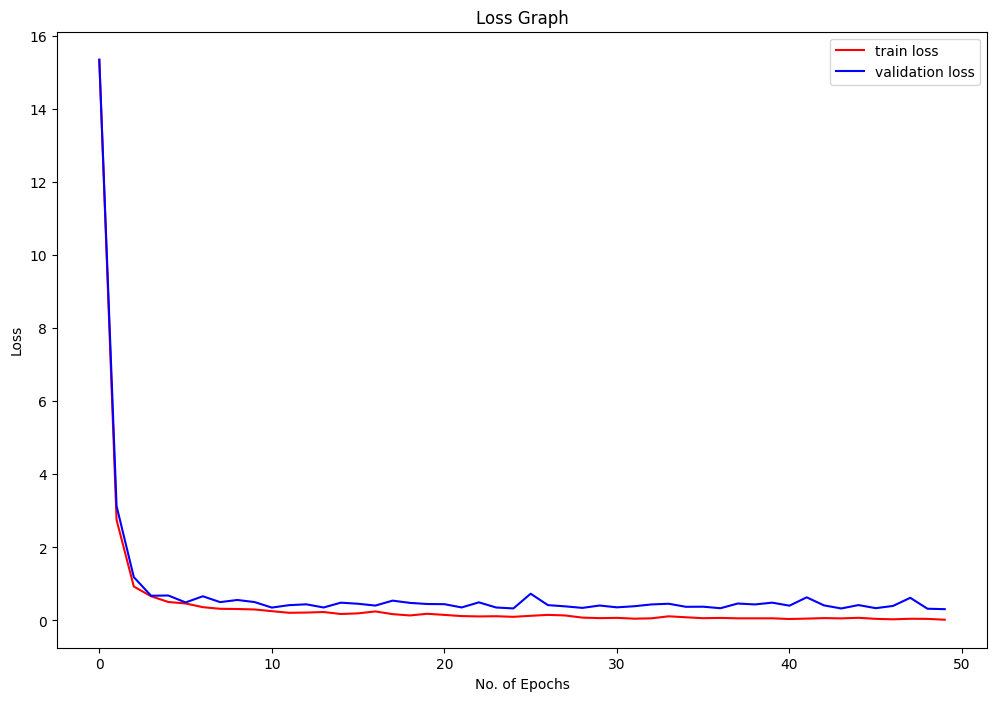

In [11]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='validation loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

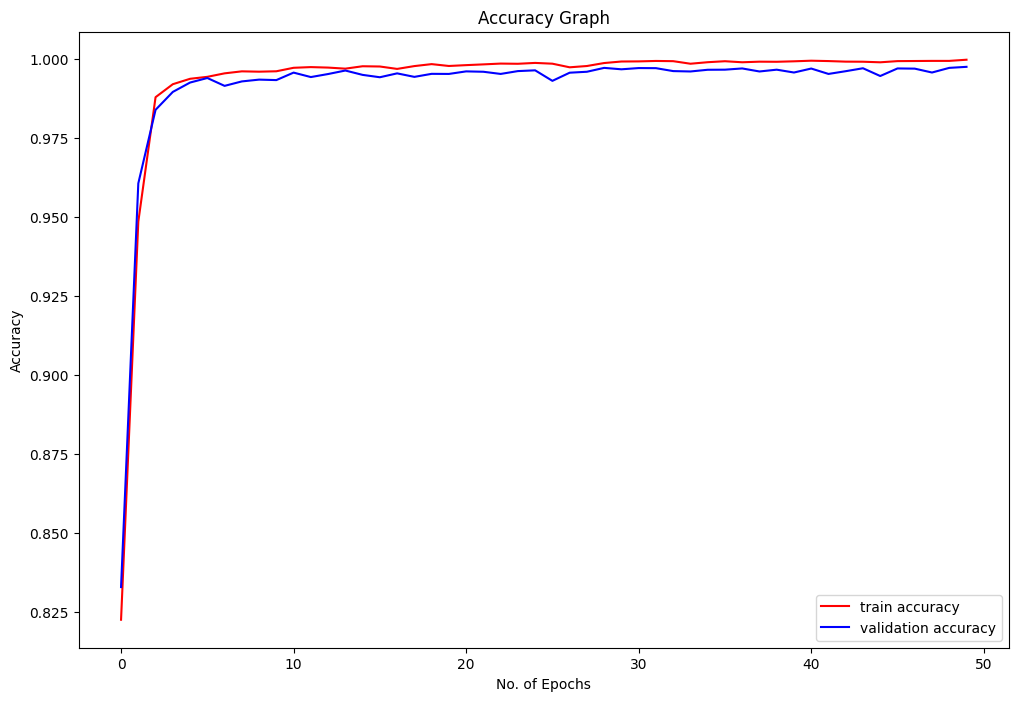

In [12]:
# Plot the accuracy graph (accuracy metric)

plt.figure(figsize=(12,8))
plt.plot(r.history['ctc_accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_ctc_accuracy'],'b',label='validation accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

### Test the Model

As our model predicts the probability for each class at each time step, we need to use some transcription function to convert it into actual texts. Here we will use the CTC decoder to get the output text.

In [13]:
# Load the saved best model weights
test_model = load_model('gdrive/MyDrive/Model/license_plate_recogniser_best_model.h5', custom_objects={'ctc_loss': ctc_loss, 'ctc_accuracy': ctc_accuracy})
 
# Predict outputs on test images
prediction = test_model.predict(X_test)
 
# Use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
 
# See the results
i = 0
for x in out:
    org_txt = ""
    for j in range(y_test.shape[1]):
        org_txt += char_list[int(y_test[i][j])]
    print("original_text  = ", org_txt)
    print("predicted text =  ", end = '')
    for p in x:  
        if int(p) != -1:
            print(char_list[int(p)], end = '')       
    print('\n')
    i+=1
    if (i == 20):
        break


34/34 [==============================] - 2s 32ms/step
original_text  =  皖AD03068
predicted text =  皖AD03068

original_text  =  皖AD01621
predicted text =  皖AD01621

original_text  =  皖ADT0901
predicted text =  皖ADT0901

original_text  =  皖AD04927
predicted text =  皖AD04927

original_text  =  皖AD16609
predicted text =  皖AD16609

original_text  =  皖ADC8252
predicted text =  皖ADC8252

original_text  =  皖AD11601
predicted text =  皖AD11601

original_text  =  皖AD05799
predicted text =  皖AD05799

original_text  =  沪AD62628
predicted text =  沪AD62628

original_text  =  皖AD11945
predicted text =  皖AD11945

original_text  =  皖AD27589
predicted text =  皖AD27589

original_text  =  皖AD07167
predicted text =  皖AD07167

original_text  =  皖AD06079
predicted text =  皖AD06079

original_text  =  皖AD09883
predicted text =  皖AD09883

original_text  =  皖AD00859
predicted text =  皖AD00859

original_text  =  皖AD08938
predicted text =  皖AD08938

original_text  =  皖AD01653
predicted text =  皖AD01653

original_te

In [14]:
# Load the saved best model
test_model = load_model('gdrive/MyDrive/Model/license_plate_recogniser_best_model.h5', custom_objects={'ctc_loss': ctc_loss, 'ctc_accuracy': ctc_accuracy})

# Test the model
loss, accuracy = test_model.evaluate(X_test, y_test, batch_size=32)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

34/34 [==============================] - 3s 34ms/step - loss: 0.5191 - ctc_accuracy: 0.9964
Test Loss: 0.5191192030906677
Test Accuracy: 0.9964390397071838
